In [1]:
#Import packages
from datascience import *
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import pandas as pd
from matplotlib import patches

<div>
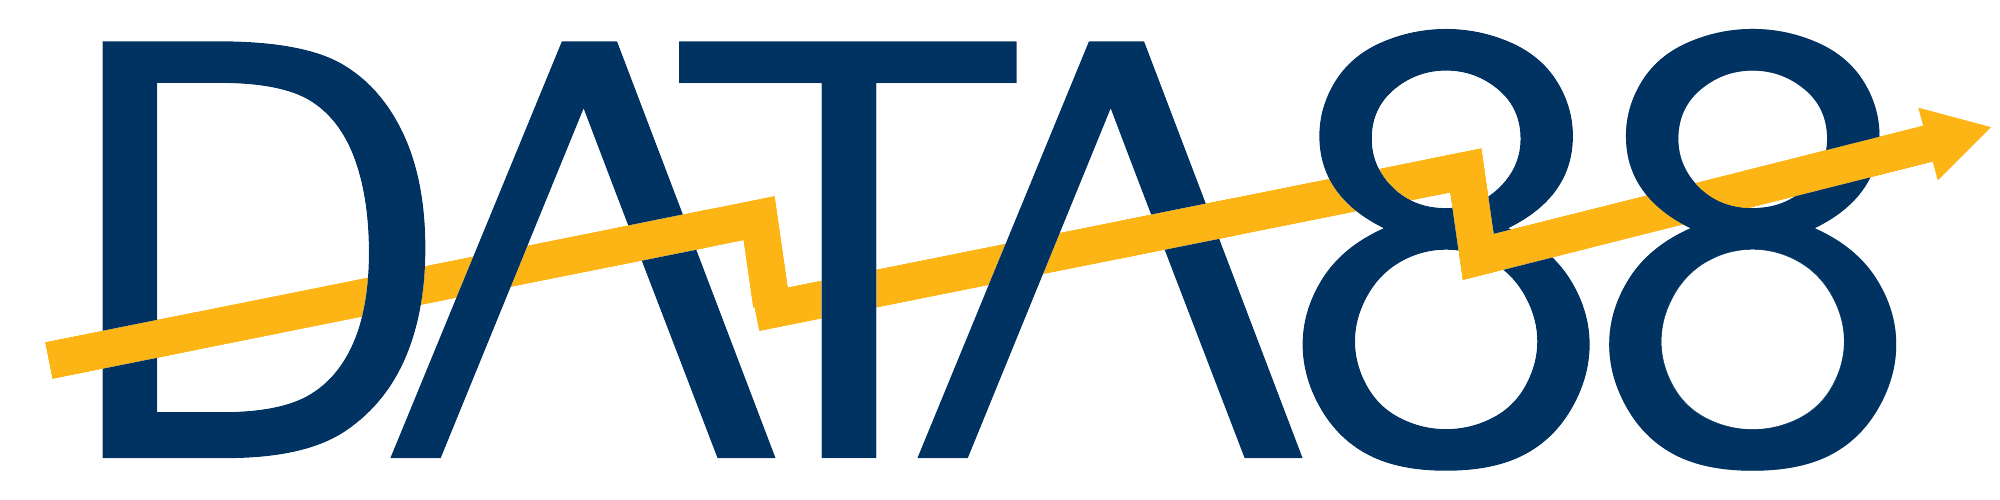
</div>



   # Constructing the Marginal Abatement Cost Curve for Methane Gas

**Written by**: Prof. Eric Van Dusen, Peter F. Grinde-Hollevik

## Learning objectives


* Understanding of how to construct the of The McKinsey Greenhouse Gas (GHG) Marginal Abatement Cost Curve (MAC).
* Understanding of how to compare different MAC curves across industries and regions.

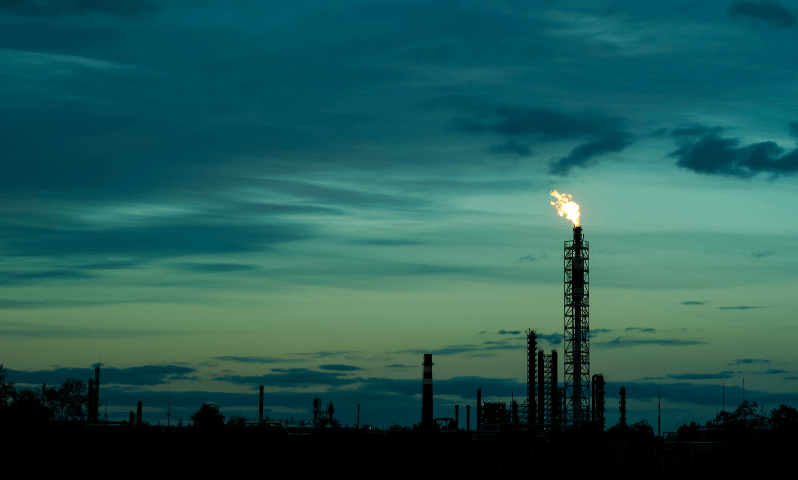

**Disclaimer:**

Please refer to the Intro to Environmental Economics chapter for a thorough introduction to MAC curves. This is a technical application of what you have learned in lecture and through your readings.

**This notebook was inspired by**: 

- Methane Emissions from Oil and Gas Report from IEA (https://www.iea.org/reports/methane-emissions-from-oil-and-gas)
- IEA Methane Tracker (2021) (https://www.iea.org/articles/methane-tracker-database).

Let's start off with a summary about global oil and gas methane emissions from their report:

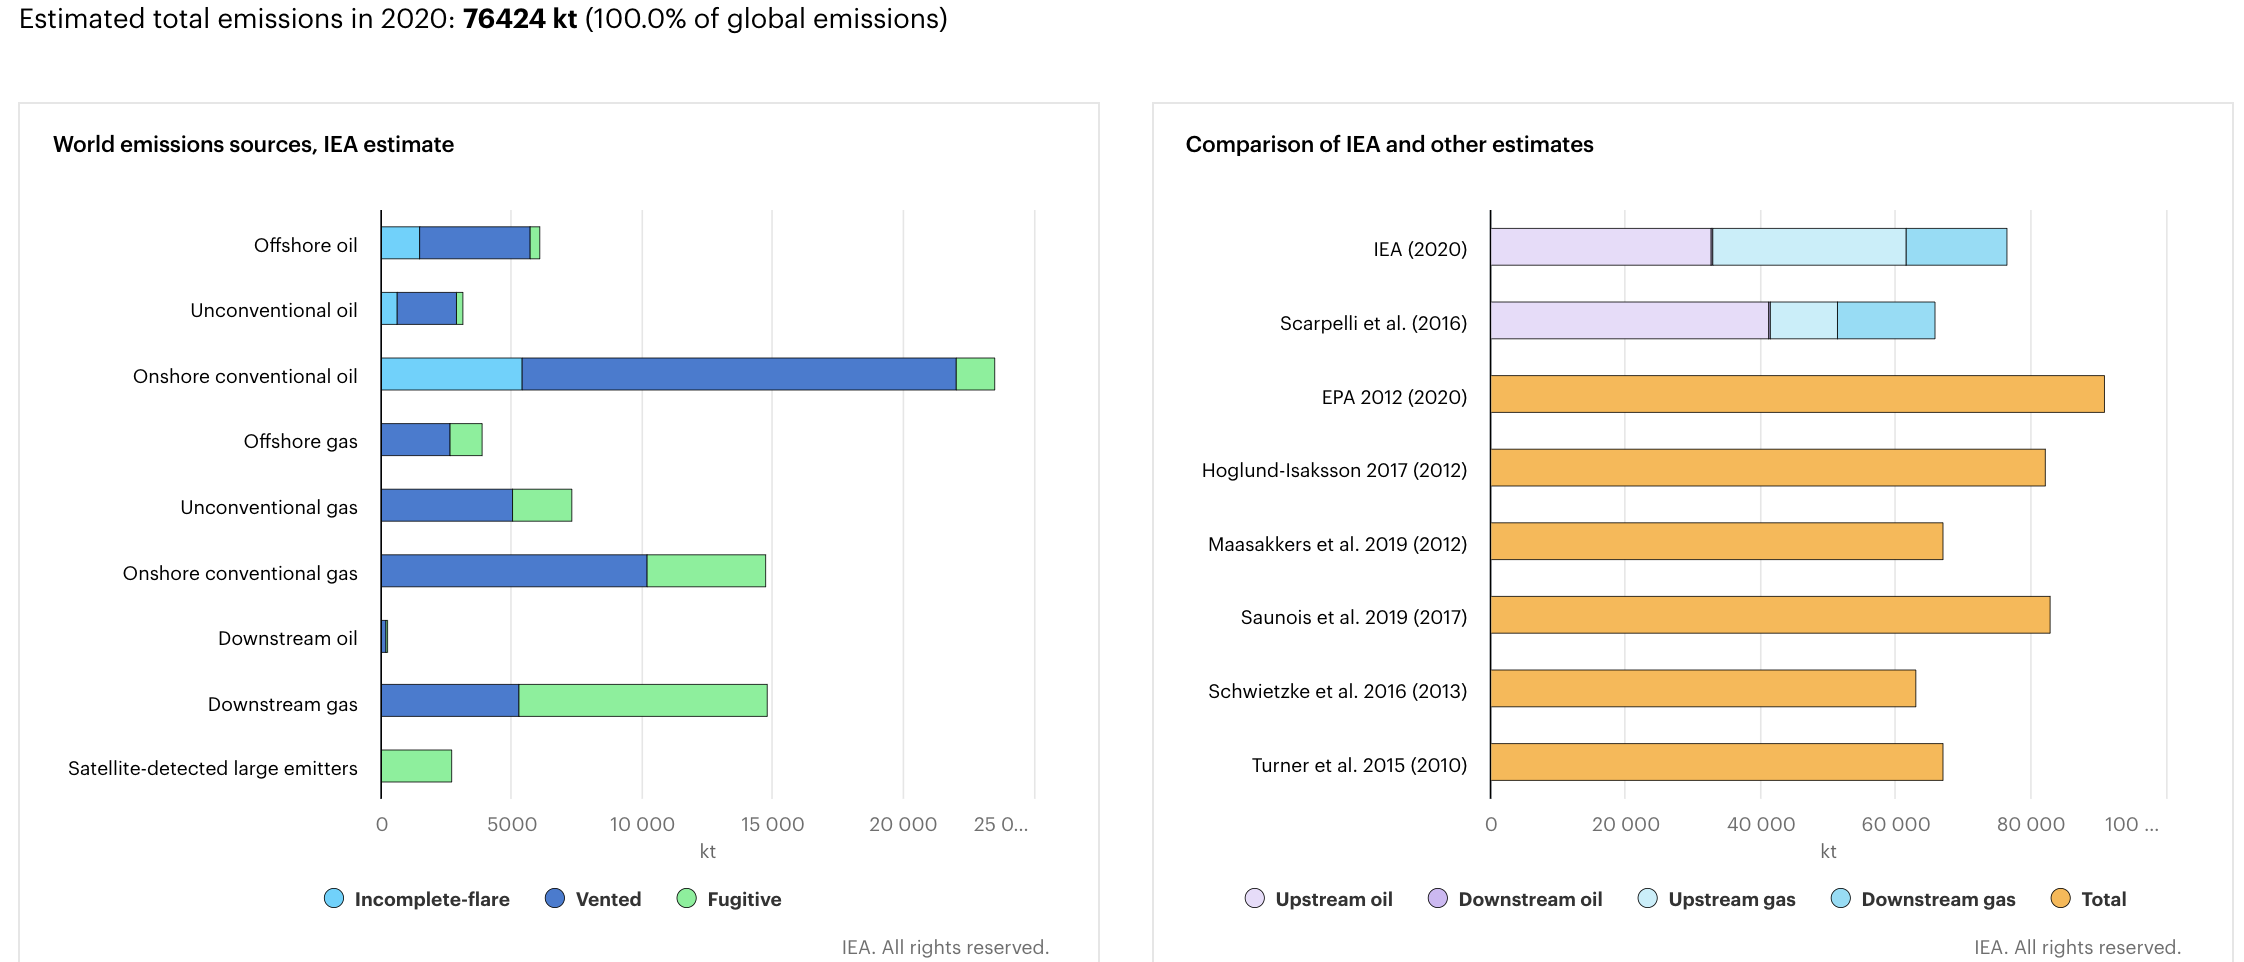

This clearly illustrates the enormous potential of methane emission abatement in the world's oil and gas sector. With high abatement potential, it is important to understand the various abatement technologies and their costs. Now, let's do exactly that!

We start by importing a dataset on methane abatement from the International Environmental Agency (IEA): 

In [2]:
#Create abatement_data table and set upper bound of abatement potential to 200
abatement_table = Table.read_table("abatement_data.csv").where('Cost',are.between(-10.1,10)).where('Possible Savings', are.below(200)).drop('Emissions').relabel('Possible Savings', 'Abatement Potential').relabel('Cost','Abatement Cost')
abatement_table

Country,Region,Oil Gas,Production source,Upstream Downstream,Reason,Abatement technology,Abatement Potential,Abatement Cost
Japan,Asia Pacific,Gas,Onshore conventional gas,Upstream,Vented,Replace pumps,0.25,-6.2
Japan,Asia Pacific,Oil,Onshore conventional oil,Upstream,Vented,Blowdown capture,0,-6.18
Japan,Asia Pacific,Gas,Offshore gas,Upstream,Vented,Replace with instrument air systems,0.02,-5.84
Japan,Asia Pacific,Oil,Offshore oil,Upstream,Vented,Replace with instrument air systems,0.01,-5.84
Japan,Asia Pacific,Gas,Downstream gas,Downstream,Vented,Replace with instrument air systems,0.62,-5.84
Japan,Asia Pacific,Oil,Offshore oil,Upstream,Vented,Replace compressor seal or rod,0,-5.58
Japan,Asia Pacific,Gas,Offshore gas,Upstream,Vented,Replace compressor seal or rod,0,-5.58
Japan,Asia Pacific,Gas,Onshore conventional gas,Upstream,Vented,Blowdown capture,0.59,-5.57
India,Asia Pacific,Gas,Offshore gas,Upstream,Vented,Replace with instrument air systems,2.75,-5.33
India,Asia Pacific,Gas,Downstream gas,Downstream,Vented,Replace with instrument air systems,0.91,-5.33


The first MAC is drawn for the Asia Pacific region. Later, our analysis becomes a comparison when we draw one for North America.

In [3]:
#Select specific region (approx. 1/4 of data)
selection = 'Asia Pacific'
abatement_table_ap = abatement_table.where('Region', selection)
abatement_table_ap

Country,Region,Oil Gas,Production source,Upstream Downstream,Reason,Abatement technology,Abatement Potential,Abatement Cost
Japan,Asia Pacific,Gas,Onshore conventional gas,Upstream,Vented,Replace pumps,0.25,-6.2
Japan,Asia Pacific,Oil,Onshore conventional oil,Upstream,Vented,Blowdown capture,0,-6.18
Japan,Asia Pacific,Gas,Offshore gas,Upstream,Vented,Replace with instrument air systems,0.02,-5.84
Japan,Asia Pacific,Oil,Offshore oil,Upstream,Vented,Replace with instrument air systems,0.01,-5.84
Japan,Asia Pacific,Gas,Downstream gas,Downstream,Vented,Replace with instrument air systems,0.62,-5.84
Japan,Asia Pacific,Oil,Offshore oil,Upstream,Vented,Replace compressor seal or rod,0,-5.58
Japan,Asia Pacific,Gas,Offshore gas,Upstream,Vented,Replace compressor seal or rod,0,-5.58
Japan,Asia Pacific,Gas,Onshore conventional gas,Upstream,Vented,Blowdown capture,0.59,-5.57
India,Asia Pacific,Gas,Offshore gas,Upstream,Vented,Replace with instrument air systems,2.75,-5.33
India,Asia Pacific,Gas,Downstream gas,Downstream,Vented,Replace with instrument air systems,0.91,-5.33


The next functions are used for plotting. First one finds the middle point in each column so that we place each abatement technology at the right place on the MAC. The seconds runs the function on our x and y axis.

In [4]:
#The find_x_pos function used for plotting! (out of scope)

def find_x_pos(widths):
    cumulative_widths = [0]
    cumulative_widths.extend(np.cumsum(widths))
    half_widths = [i/2 for i in widths]
    x_pos = []
    for i in range(0, len(half_widths)):
        x_pos.append(half_widths[i] + cumulative_widths[i])
    return x_pos

#Prepare the data for plotting
width_group = abatement_table_ap.column('Abatement Potential')
height_group = abatement_table_ap.column('Abatement Cost')
new_x_group = find_x_pos(width_group)

With the following function, we introduce an arbritary level of taxation to measure the total abatement outcome later.

In [5]:
#The methane_tax function -- Let's introduce a tax!
def methane_tax(tax, table):
    if tax < min(table.column('Abatement Cost')):
        print("No Abatement")
    else:
        abatement = table.where('Abatement Cost', are.below_or_equal_to(tax))
        total_abatement = sum(abatement.column('Abatement Potential'))
        abatement_technologies = abatement.column('Abatement technology')
        
        print('Total Abatement: ', total_abatement)
        print("")
        #print("Abatement Technologies", abatement_technologies)

The next function takes the methane_tax function and does plotting magic. Try to understand what each "plt" part does if you're interested!

Methane: $4
Total Abatement:  4579.399996707216



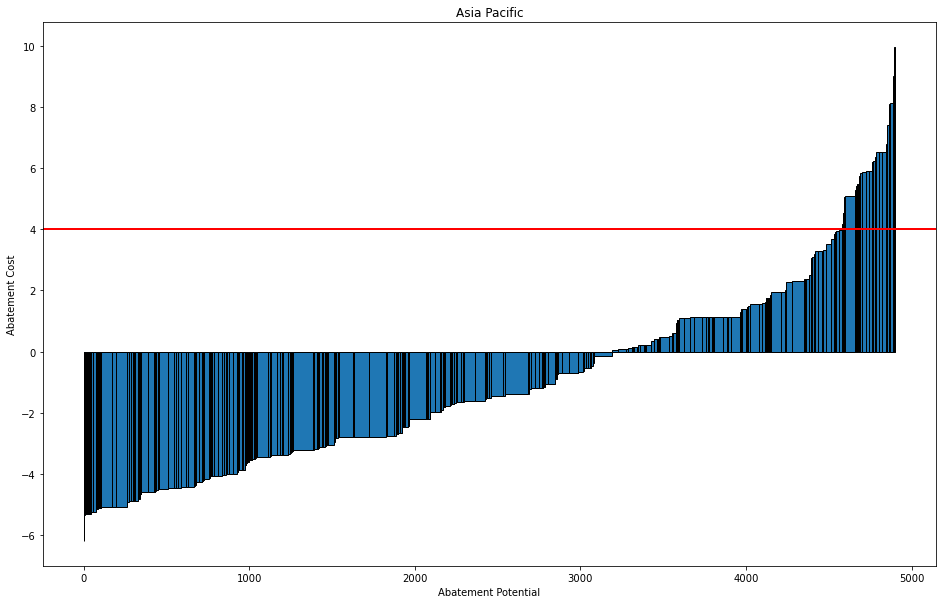

In [10]:
#The group_plot function used for plotting (out of scope)
def group_plot(tax, table):
    print(f"Methane: ${tax}")
    methane_tax(tax, table)
    plt.figure(figsize=(16,10))
    plt.bar(new_x_group, height_group,width=width_group,edgecolor = 'black')
    plt.title(selection)
    plt.xlabel('Abatement Potential')
    plt.ylabel('Abatement Cost')
    plt.axhline(y=tax, color='r',linewidth = 2)
    
group_plot(4, abatement_table_ap)

And here it is! Our first MAC for Methane in Asia Pacific. What strikes you the most? Right now, there's only one caveat: How can we differentiate the abatement technologies? The solution to this is giving each a different color from a Python dictionary.

In [11]:
#Prepare data for plotting (second round)
width = abatement_table_ap.column('Abatement Potential')
height = abatement_table_ap.column('Abatement Cost')
new_x = find_x_pos(width)

#Let's give each type of technology a different color!
abatement_colors_dict = {}
count = 0
colors = ['#EC5F67', '#F29056', '#F9C863', '#99C794', '#5FB3B3', '#6699CC', '#C594C5','#85E827','#F165FD','#1F9F7F','#945CF8','#ff3a1d','#2a8506']
for i in set(abatement_table_ap['Abatement technology']):
    abatement_colors_dict[i] = colors[count]
    count += 1

colors_mapped = list(pd.Series(abatement_table_ap['Abatement technology']).map(abatement_colors_dict))
abatement_table_ap = abatement_table_ap.with_column('Color', colors_mapped)

Methane Tax: $3
Total Abatement:  4392.599997341633



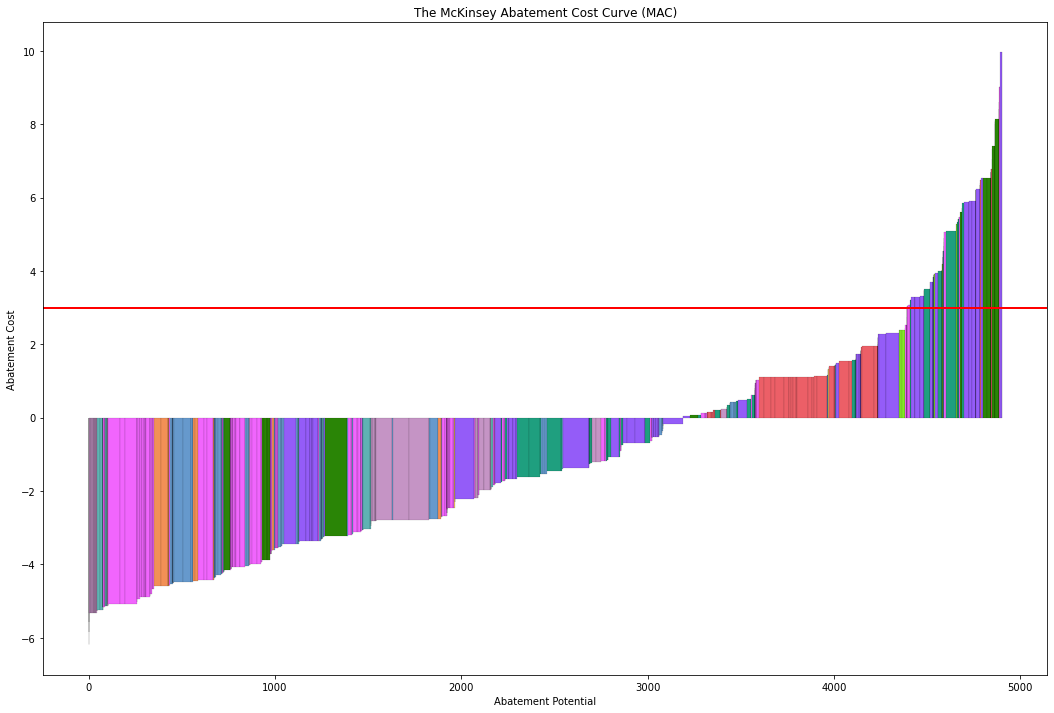

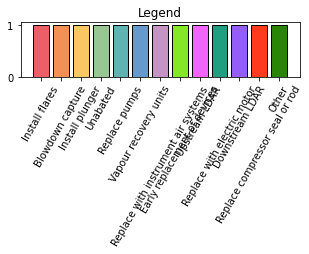

In [12]:
#The Methane curve plot - function!
def mckinsey_curve(tax, abatement_table):
    print(f"Methane Tax: ${tax}")
    methane_tax(tax, abatement_table)
    plt.figure(figsize=(18,12))
    plt.bar(new_x, height, width=width, linewidth=0.1, color=abatement_table['Color'], edgecolor = "black")
    plt.title('The McKinsey Abatement Cost Curve (MAC)')
    plt.xlabel('Abatement Potential')
    plt.ylabel('Abatement Cost')
    plt.axhline(y=tax, color='r', linewidth = 2)

    plt.figure(figsize=(5,1))
    plt.bar(abatement_colors_dict.keys(), 1, color = abatement_colors_dict.values())
    plt.xticks(rotation=60)
    plt.title('Legend')
    
mckinsey_curve(3, abatement_table_ap)

What a plot! From here, we can differentiate the multiple methane abatement technologies on a cost basis, finding the most efficient ways of reducing methane emissions from gas production. We also observe the result of introducing a tax: With a tax of $3 per ton, we expect the total abatement to be almost 20.000 tons within our industry.

### Now, repreating the process for North America:

Methane Tax: $3
Total Abatement:  2863.1800029147416



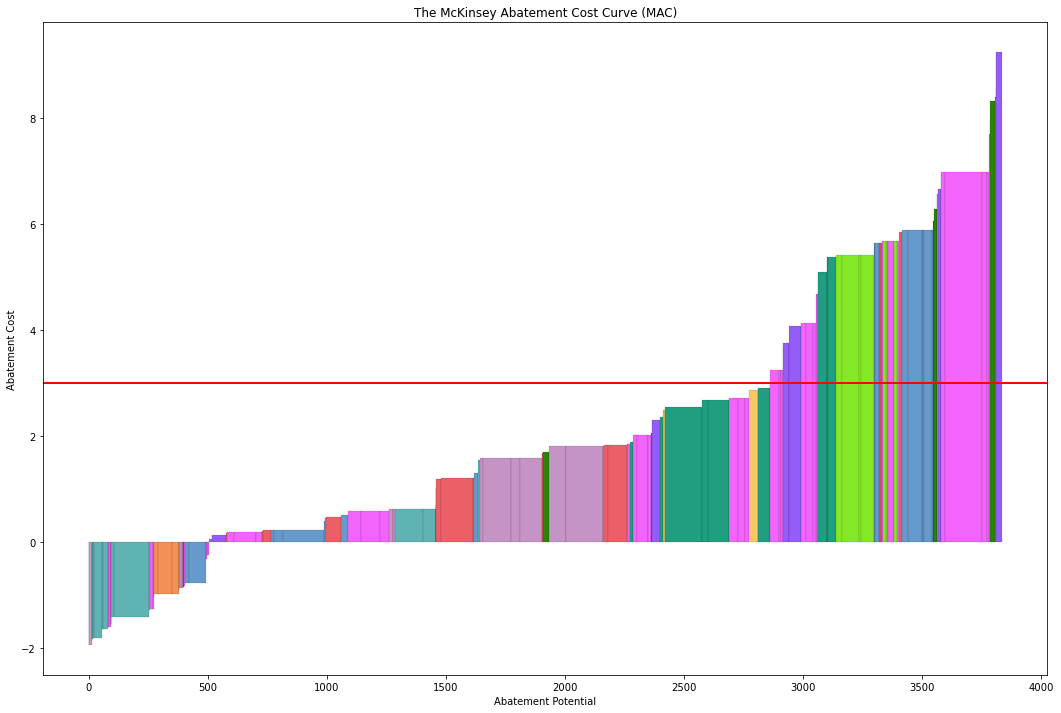

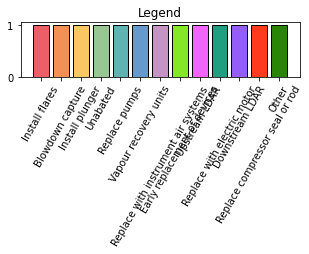

In [13]:
#Create abatement_data table and set upper bound of abatement potential to 200
abatement_table = Table.read_table("abatement_data.csv").where('Cost',are.between(-10.1,10)).where('Possible Savings', are.below(200)).drop('Emissions').relabel('Possible Savings', 'Abatement Potential').relabel('Cost','Abatement Cost')
abatement_table

selection = 'North America'
abatement_table_us = abatement_table.where('Region', selection)
abatement_table_us

#Prepare data for plotting (second round)
width = abatement_table_us.column('Abatement Potential')
height = abatement_table_us.column('Abatement Cost')
new_x = find_x_pos(width)

#Let's give each type of technology a different color!
abatement_colors_dict = {}
count = 0
colors = ['#EC5F67', '#F29056', '#F9C863', '#99C794', '#5FB3B3', '#6699CC', '#C594C5','#85E827','#F165FD','#1F9F7F','#945CF8','#ff3a1d','#2a8506']
for i in set(abatement_table_us['Abatement technology']):
    abatement_colors_dict[i] = colors[count]
    count += 1

colors_mapped = list(pd.Series(abatement_table_us['Abatement technology']).map(abatement_colors_dict))
abatement_table_us = abatement_table_us.with_column('Color', colors_mapped)

mckinsey_curve(3, abatement_table_us)

### And all regions:

Methane Tax: $3
Total Abatement:  19371.639972971752



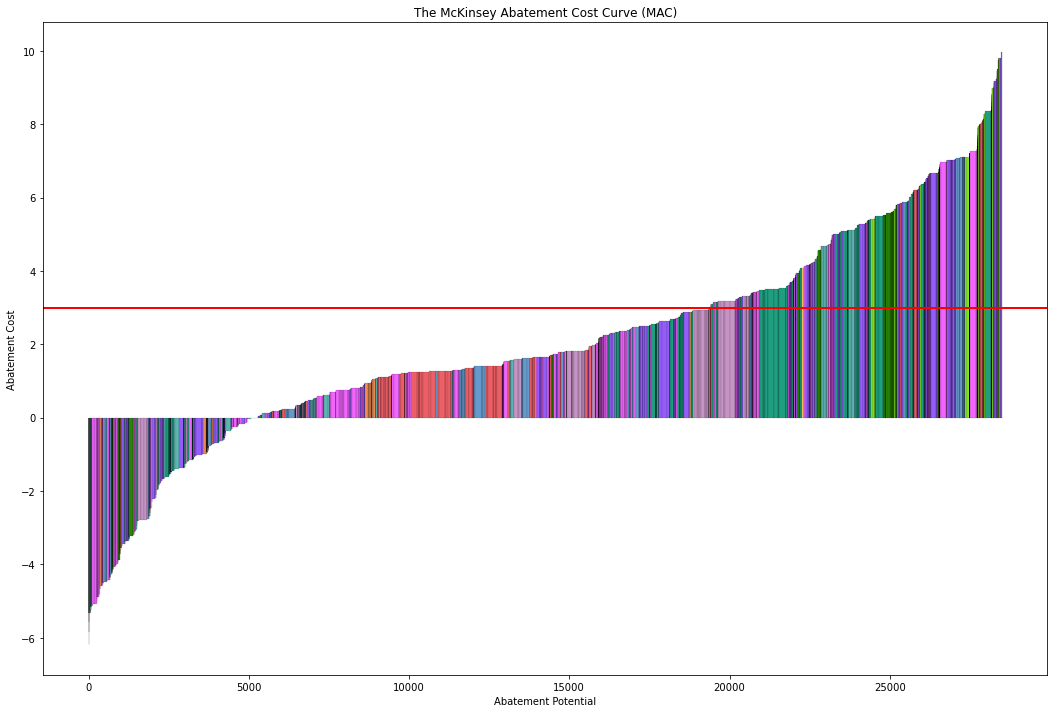

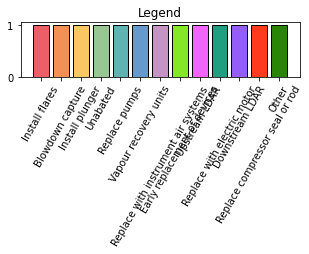

In [15]:
#Create abatement_data table and set upper bound of abatement potential to 200
abatement_table = Table.read_table("abatement_data.csv").where('Cost',are.between(-10.1,10)).where('Possible Savings', are.below(200)).drop('Emissions').relabel('Possible Savings', 'Abatement Potential').relabel('Cost','Abatement Cost')
abatement_table



#Prepare data for plotting (second round)
width = abatement_table.column('Abatement Potential')
height = abatement_table.column('Abatement Cost')
new_x = find_x_pos(width)

#Let's give each type of technology a different color!
abatement_colors_dict = {}
count = 0
colors = ['#EC5F67', '#F29056', '#F9C863', '#99C794', '#5FB3B3', '#6699CC', '#C594C5','#85E827','#F165FD','#1F9F7F','#945CF8','#ff3a1d','#2a8506']
for i in set(abatement_table['Abatement technology']):
    abatement_colors_dict[i] = colors[count]
    count += 1

colors_mapped = list(pd.Series(abatement_table['Abatement technology']).map(abatement_colors_dict))
abatement_table = abatement_table.with_column('Color', colors_mapped)

mckinsey_curve(3, abatement_table)


### Challenge for the student:

You might have noticed how the author of this chapter (Peter) repeats certain lines of code. My challenge to you would be to find these lines and write one big function (or multiple small ones) that streamlines the whole process. Let me know at hollevik@berkeley.edu when you figure it out! 